In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter, FormatStrFormatter
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch
from scipy.signal import convolve

import geopandas as gpd
import pyogrio
import rasterio
from rasterio.mask import mask
from pyproj import CRS
from shapely.geometry import Point

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [4]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [5]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CSG/'

# Prepare Data

Using old data, needs to be updated to new actual-ideal dataset

In [6]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8']
ncols = (len(regions) + 1) // 2 # plotting
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/V1.0/clear_sky_generation/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
ds = ds.load()
# Assign Brisbane time
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

### Remove the 3 bad days

In [7]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

### Assign "time of year" coordinate for bias correction

In [8]:
ds = ds.assign_coords(
        time_of_year=ds['time'].dt.strftime("%m-%d")
    )

### Remove dusk and dawn data

In [9]:
# REMOVE BAD DUSK AND DAWN DATA
for reg in regions:
    ds[reg] = solar_plotting.clip_dusk_dawn(ds[reg], n=6)

# Bias Analysis

In [10]:
# Only look at the middle hours when finding biases
mask = (ds['time'].dt.hour > 10) & (ds['time'].dt.hour < 15)

In [11]:
def get_bias(da):
    # prevent actual cloudy data from bringing down mean
    da = da.clip(min=0.95)
    da_biases = da.rolling(time_of_year=30, center=True, min_periods=1).max()
    da_biases_smooth = da_biases.rolling(time_of_year=100, center=True, min_periods=1).mean()
    return da_biases_smooth

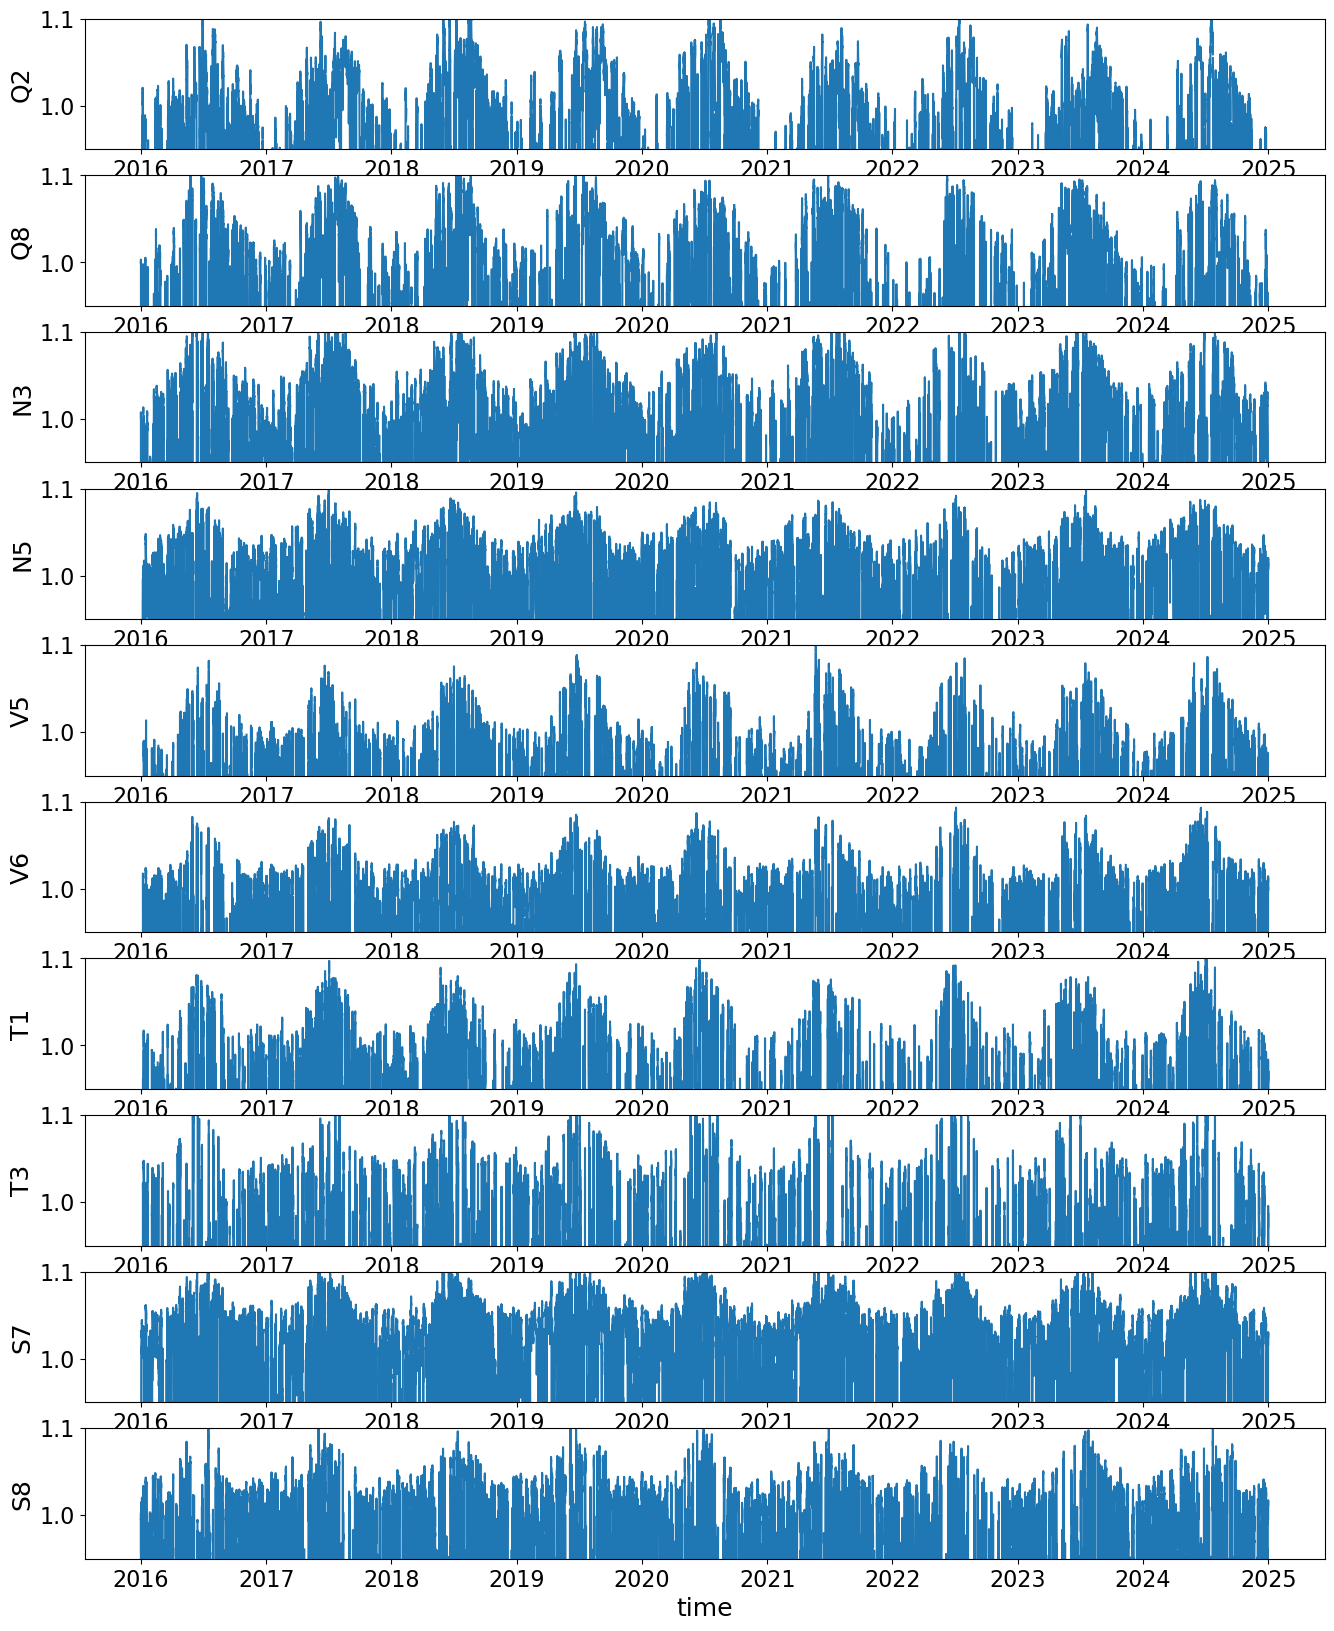

In [12]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ds[reg][mask].plot(ax=ax[i])
    ax[i].set_ylim(0.95, 1.1)

<Axes: >

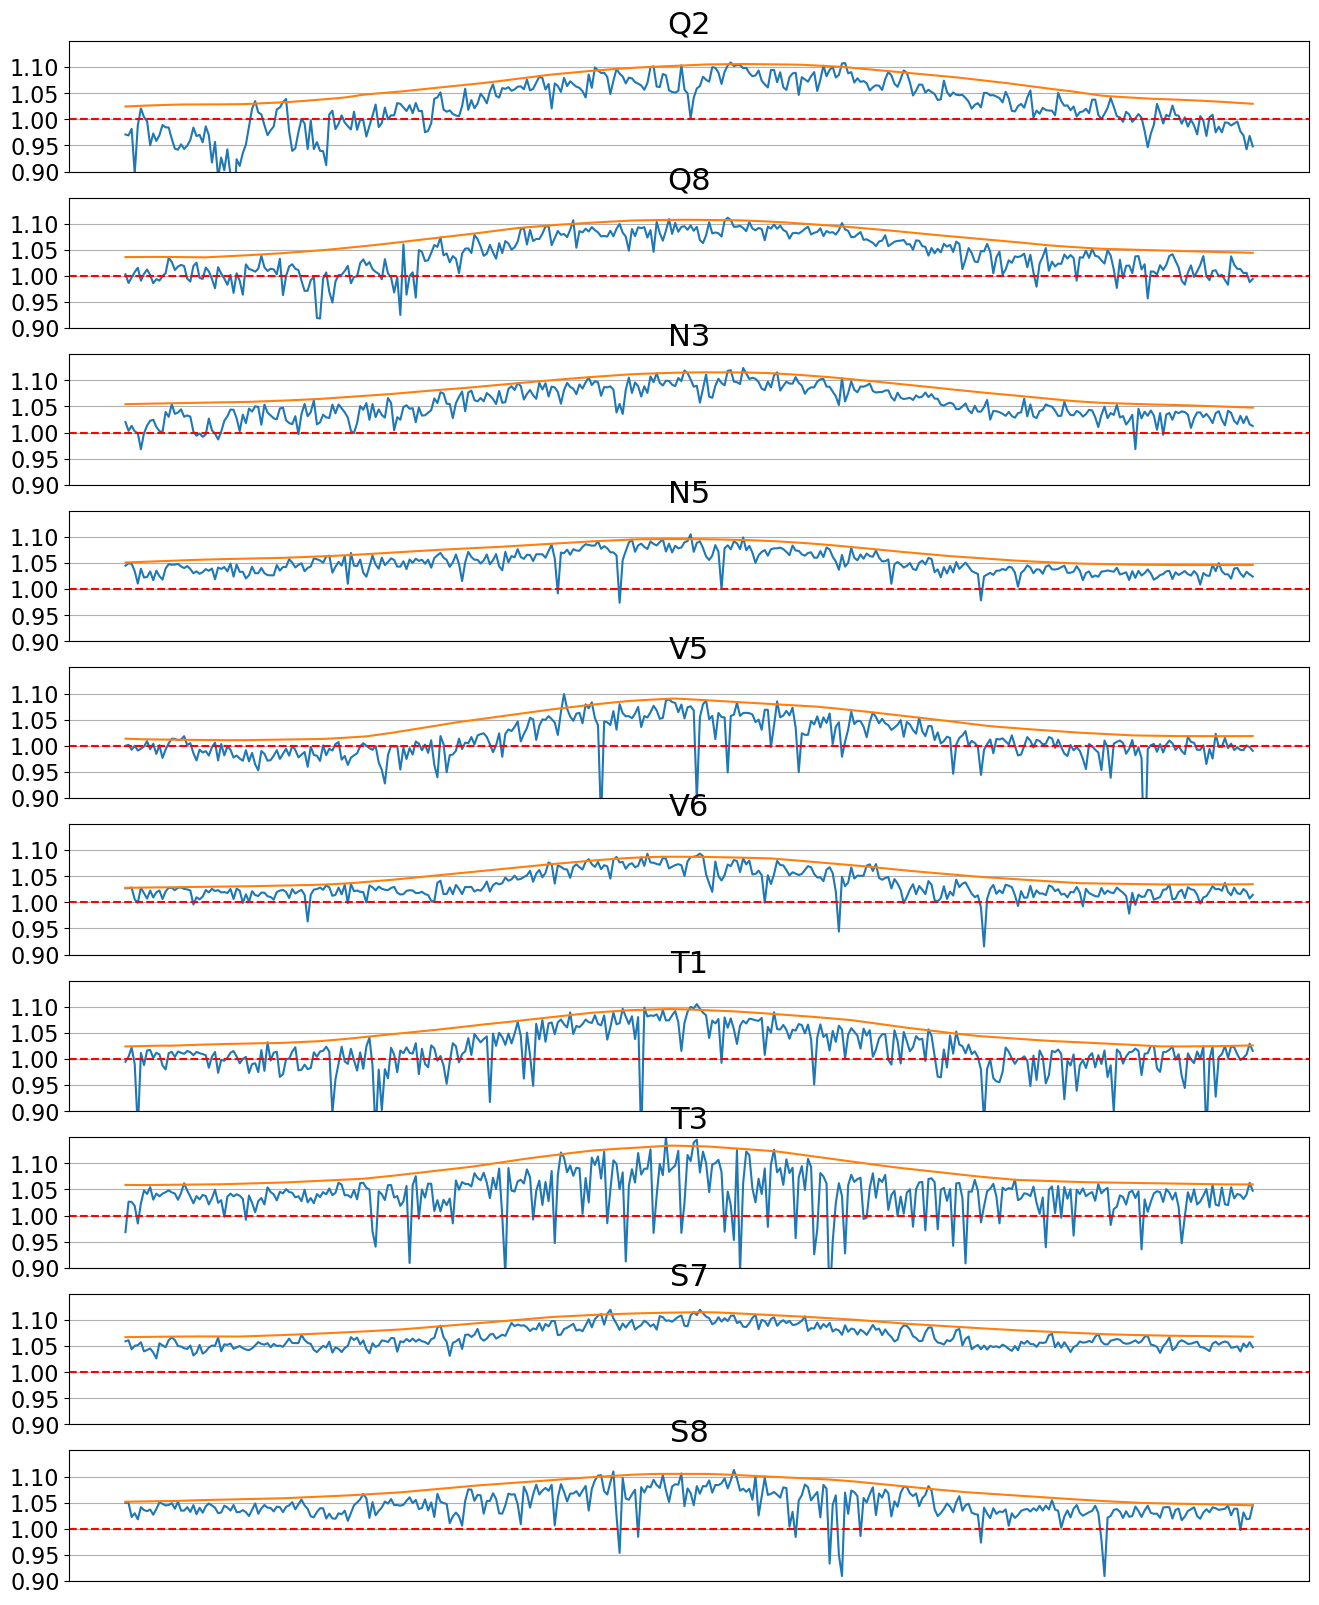

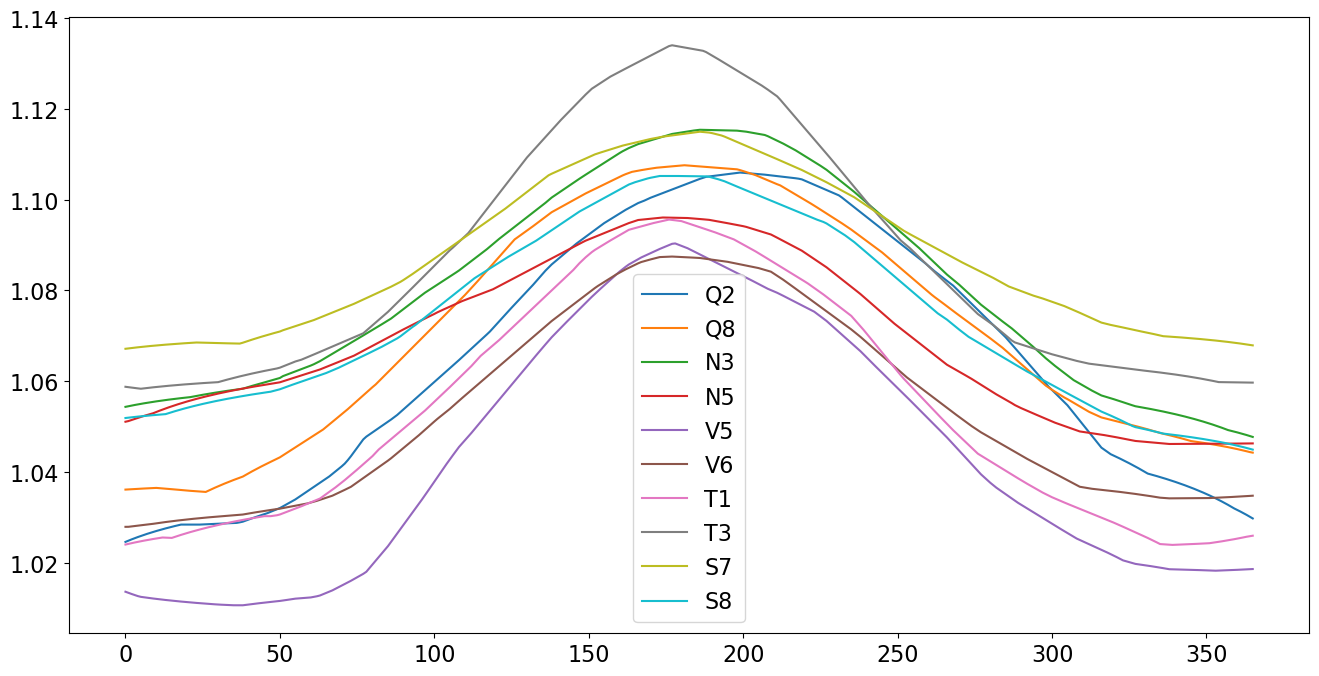

In [13]:
bias = {}
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ax[i].plot(ds[reg][mask].groupby('time_of_year').max().values)
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ax[i].plot(reg_bias.values)
    bias[reg] = reg_bias.values
    ax[i].set_ylim(0.9, 1.15)
    ax[i].set_yticks([1])
    ax[i].axhline(1, color='r', linestyle='--')
    ax[i].set_yticks(np.linspace(0.9, 1.1, 5))
    ax[i].set_xticks([])
    ax[i].set_title(reg)
    ax[i].grid(True)
bias_df = pd.DataFrame(
    bias,
    # index=ds_aus.resample(time='1D').max().time
)
bias_df.plot(figsize=(16,8))

# Bias Correction

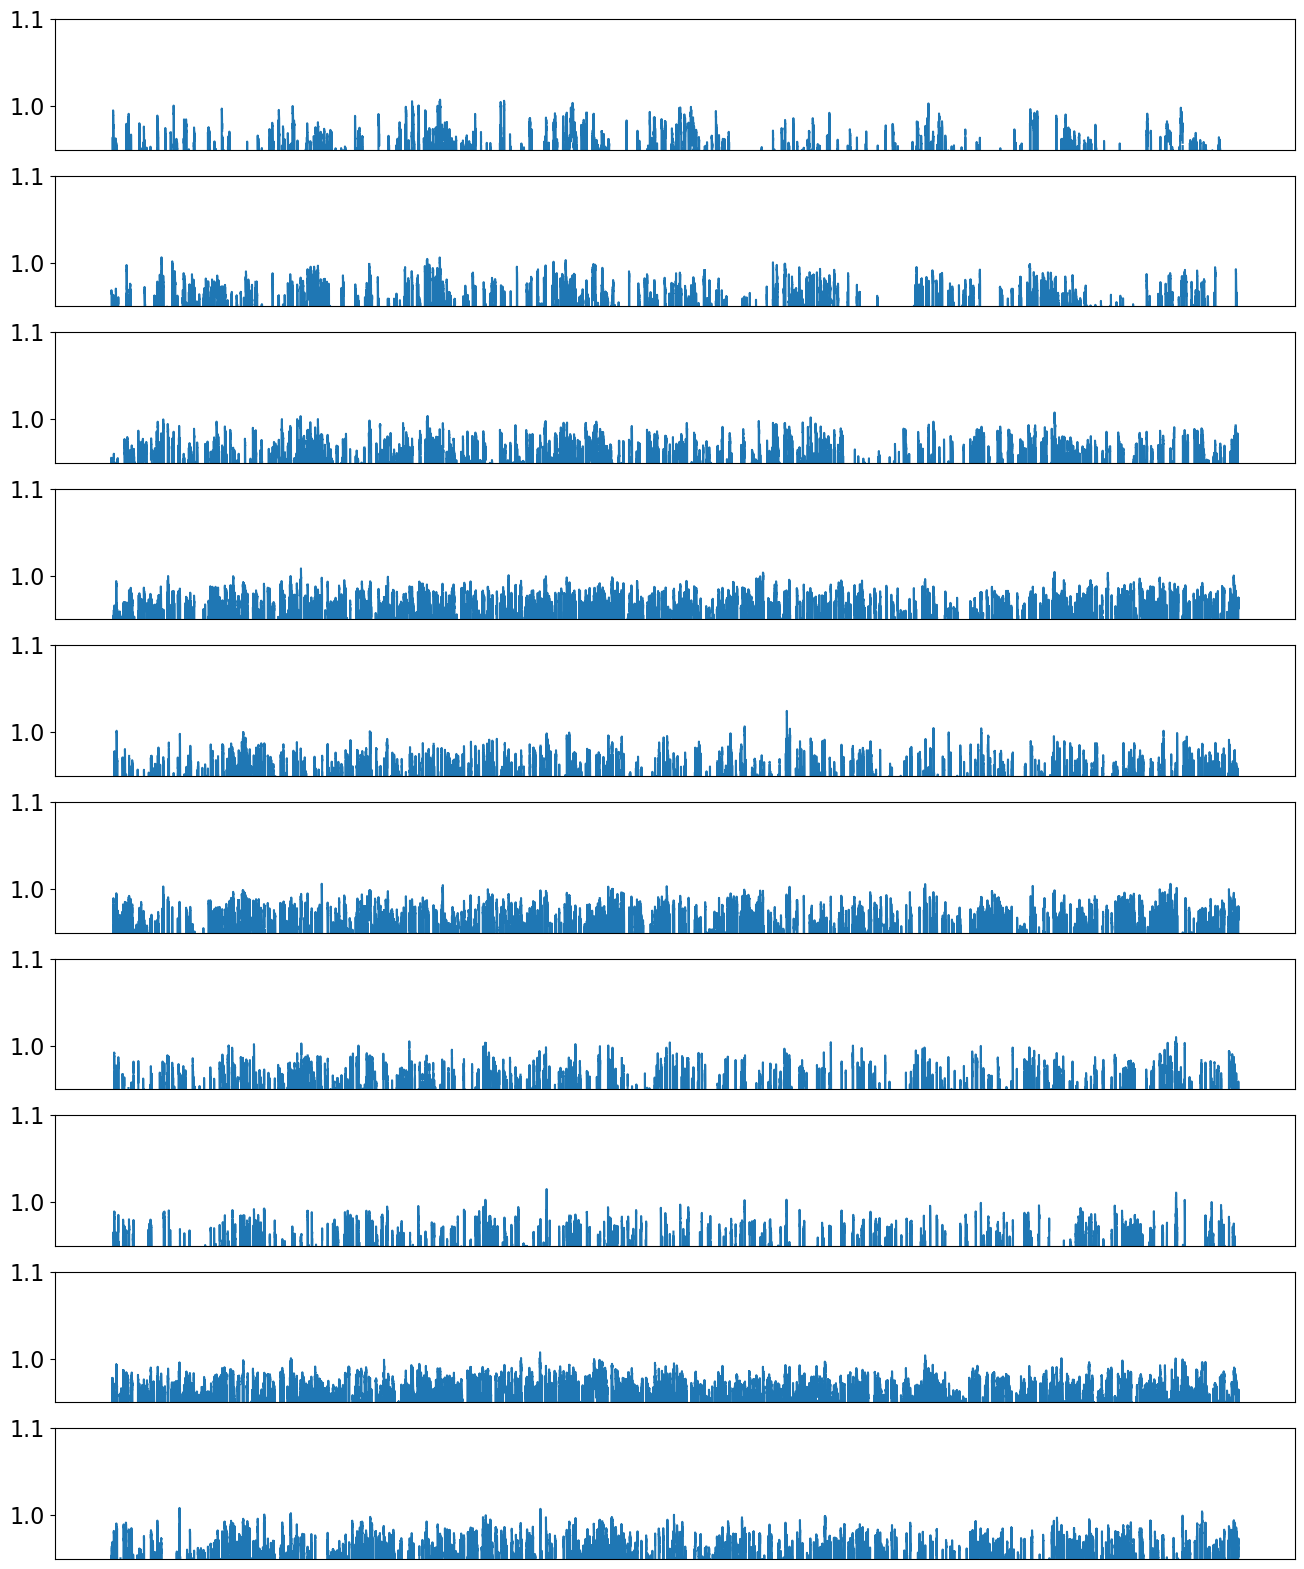

In [14]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ds[reg] = ds[reg].groupby('time_of_year') / reg_bias
    ax[i].plot(ds[reg][mask])
    ax[i].set_xticks([])
    ax[i].set_ylim(0.95, 1.1)

### Clip remaining values above 1

In [15]:
ds = ds.clip(max=1)

# Remove missing middle of the day time

In [16]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)